# 1) Inialization

## 1.1) Import utilities

In [9]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


## 1.2) Define models

In [10]:
# Config and data files
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn_a = ['/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_14_valid.nc',
             '/local/Tom.Beucler/SPCAM_PHYS/8col009_31_valid.nc']
data_ref = ['','4K','3Kw1']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,\
           'weak_loss_0':mse,'weak_loss_1':mse}
NNarray = ['JNNL','JNNC','MLRL0','JNNL0.01']

# 2) Test where the generalization error for convective heating and moistening is most obvious for different types of networks

In [17]:
# Indices of different variables
PHQ_idx = slice(0, 30)
PHCLDLIQ_idx = slice(30, 60)
PHCLDICE_idx = slice(60, 90)
TPHYSTND_idx = slice(90, 120)

In [79]:
lat_ind = [31,32] # index over which we evaluate generalization performances
iini = 4000
iend = 4015
index = 1; # Choose dataset from data_fn_a [0 is +0K of length 5172, 1 is +4K of length ???]

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = TRAINDIR+'HDF5_DATA/'+NNs+'.h5'
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = ModelDiagnostics(NN[NNs],config_fn,data_fn_a[index])

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
NN name is  JNNL


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNC


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  MLRL0


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


NN name is  JNNL0.01


/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [80]:
diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    diagno[NNs] = {} # Diagnostics structure for each NN
    for itime in tqdm(np.arange(iini,iend)):
        # Get input, prediction and truth from NN
        inp, p, truth = md[NNs].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
        # Get convective heating and moistening for each NN
        if itime==iini:
            if i==0:
                diagno['truth']['PHQ'] = md[NNs].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                diagno['truth']['TPHYSTND'] = md[NNs].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['PHQ'] = md[NNs].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
            diagno[NNs]['TPHYSTND'] = md[NNs].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
        else:
            for istr,field in enumerate(['PHQ','TPHYSTND']):
                diagno[NNs][field] = np.concatenate((diagno[NNs][field],
                                                     md[NNs].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]),
                                                    axis=3)
                if i==0:
                    diagno['truth'][field] = np.concatenate((diagno['truth'][field],
                                                             md[NNs].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)

## Idea = Systematic biases should be visible in the mean

In [84]:
# Load coordinates
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [85]:
# Plot characteristics
fz = 15
lw = 2
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

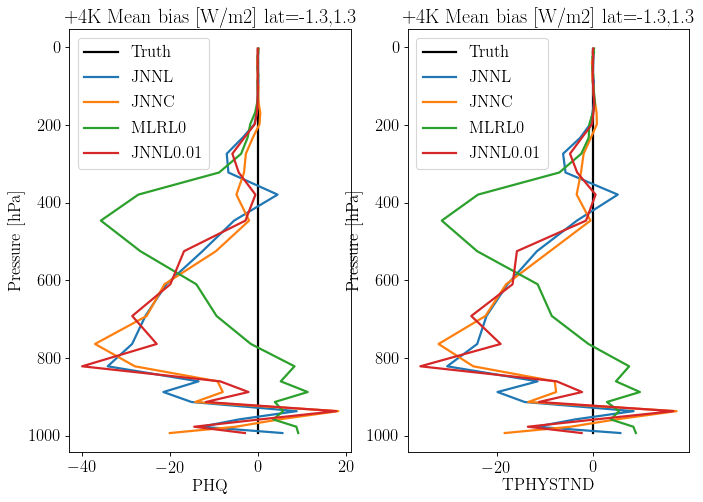

In [87]:
option = 'bias' # Full profile vs profile bias

f = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')

for ifig,field in enumerate(['PHQ','TPHYSTND']):
    ax = f.add_subplot(1,2,ifig+1)
    if option=='full': plt.plot(np.mean(diagno['truth'][field],axis=(0,1,3)),lev,label='Truth',color='k')
    elif option=='bias': plt.plot(0*lev**0,lev,label='Truth',color='k')
    for i,NNs in enumerate(NNarray):
        if option=='full': plt.plot(np.mean(diagno[NNs][field],axis=(0,1,3)),lev,label=NNs)
        elif option=='bias': plt.plot(np.mean(diagno[NNs][field]-diagno['truth'][field],axis=(0,1,3)),lev,label=NNs)
    plt.legend()
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure [hPa]')
    plt.xlabel(field)
    if option=='full': plt.title('+4K Mean [W/m2] lat=-1.3,1.3')
    elif option=='bias': plt.title('+4K Mean bias [W/m2] lat=-1.3,1.3')